/Users/georgye/Documents/repos/ethz/dslab25/venv/dslab_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading COCO annotations from: /Users/georgye/Documents/repos/ethz/dslab25/training/vacuum_pump/coco_annotations.json


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Total valid samples found: 45144
Loading image processor...
Using device: cpu
Loading model structure...


Some weights of Dinov2WithRegistersForImageClassification were not initialized from the model checkpoint at facebook/dinov2-with-registers-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model weights from: /Users/georgye/Documents/repos/ethz/dslab25/obj_detection/dino/final_model/model.safetensors

--- Starting Evaluation on Random Samples ---


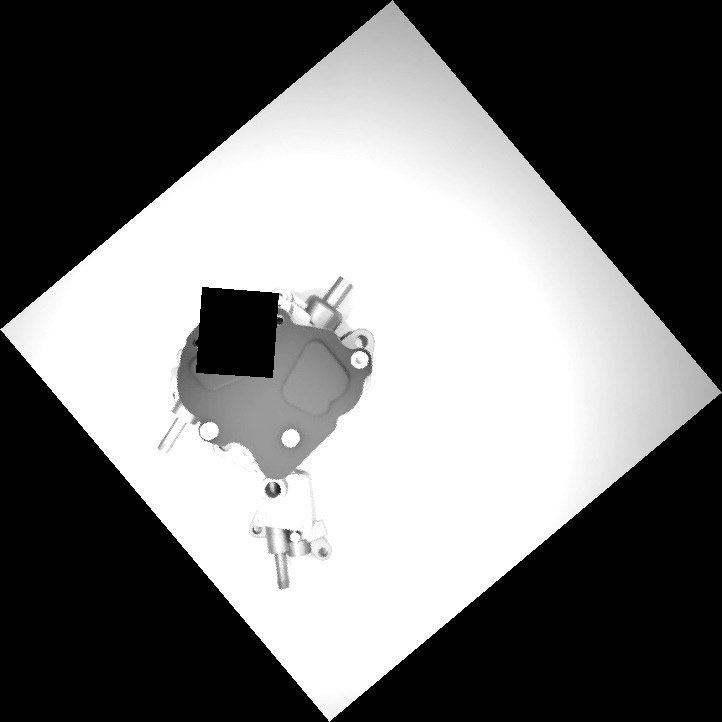

Sample 1/10:
Image: stage_7_perm_26_case_render_6_rot220_bright125_obscure.jpg
True Label: stage_7 (ID: 7)
Predicted Label: stage_7 (ID: 7)
Result: ✅ CORRECT
----------------------------------------


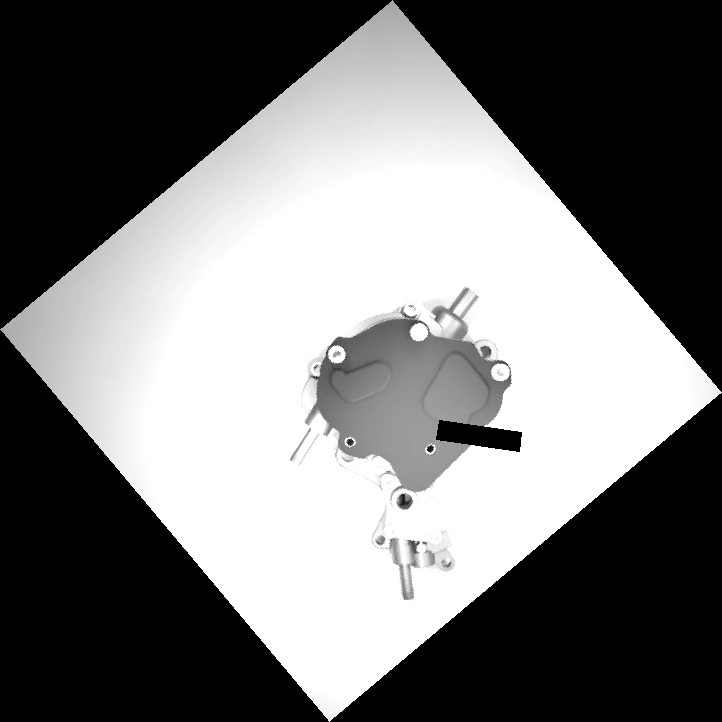

Sample 2/10:
Image: stage_7_perm_21_case_render_8_rot220_bright125_obscure.jpg
True Label: stage_7 (ID: 7)
Predicted Label: stage_7 (ID: 7)
Result: ✅ CORRECT
----------------------------------------


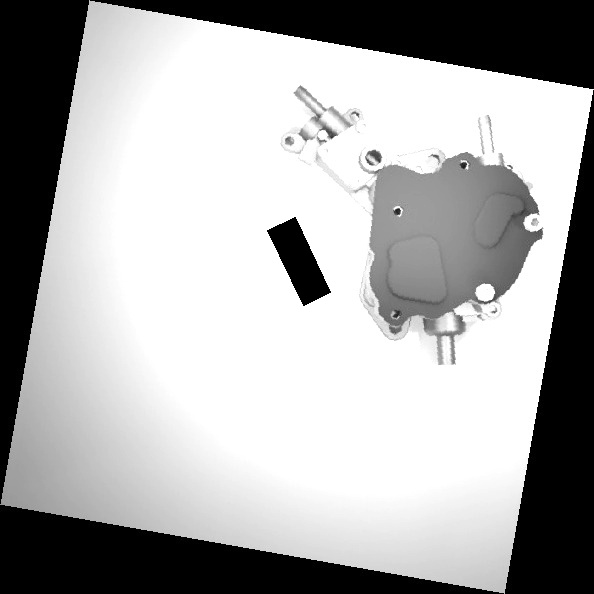

Sample 3/10:
Image: stage_7_perm_5_case_render_3_rot80_bright125_obscure.jpg
True Label: stage_7 (ID: 7)
Predicted Label: stage_7 (ID: 7)
Result: ✅ CORRECT
----------------------------------------


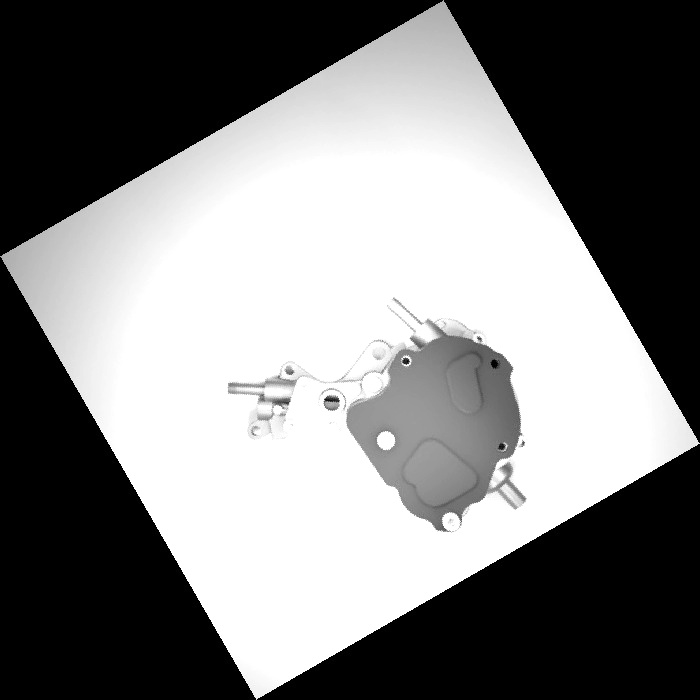

Sample 4/10:
Image: stage_7_perm_24_case_render_4_rot120_bright125.jpg
True Label: stage_7 (ID: 7)
Predicted Label: stage_6 (ID: 6)
Result: ❌ INCORRECT
----------------------------------------


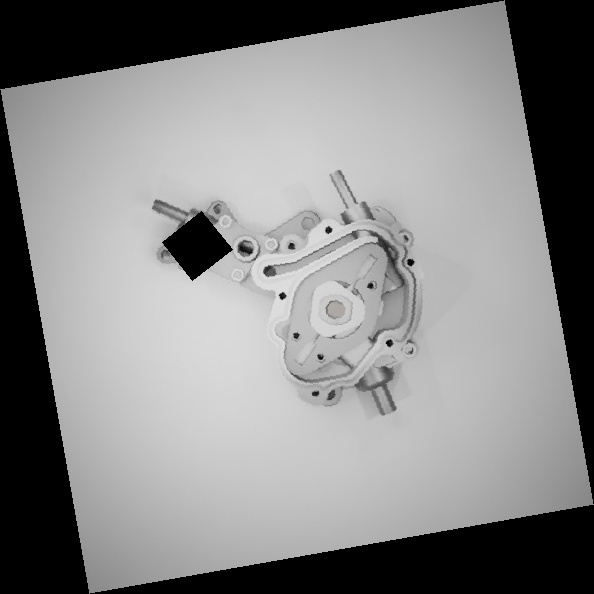

Sample 5/10:
Image: stage_5_perm_5_case_render_5_rot100_obscure.jpg
True Label: stage_5 (ID: 5)
Predicted Label: stage_5 (ID: 5)
Result: ✅ CORRECT
----------------------------------------


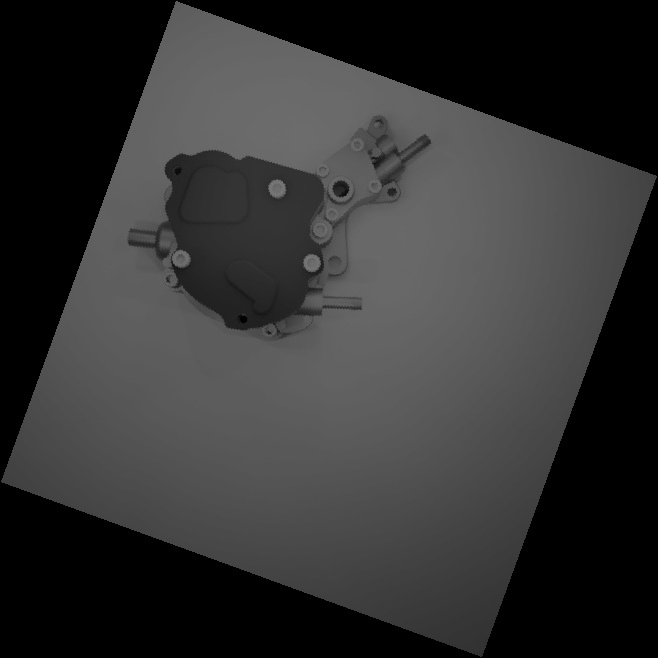

Sample 6/10:
Image: stage_7_perm_11_case_render_7_rot340_dark075.jpg
True Label: stage_7 (ID: 7)
Predicted Label: stage_7 (ID: 7)
Result: ✅ CORRECT
----------------------------------------


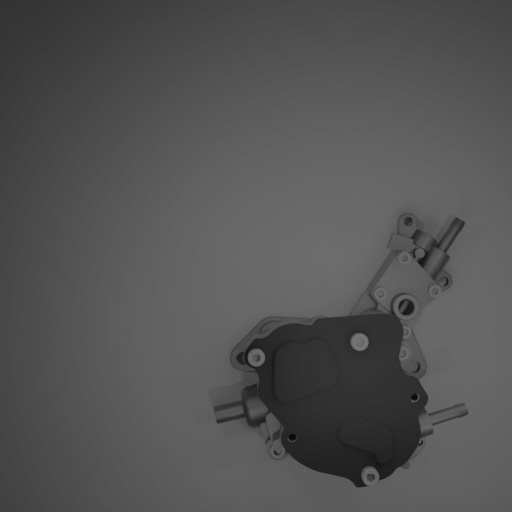

Sample 7/10:
Image: stage_7_perm_28_case_render_3_rot360_dark075.jpg
True Label: stage_7 (ID: 7)
Predicted Label: stage_7 (ID: 7)
Result: ✅ CORRECT
----------------------------------------


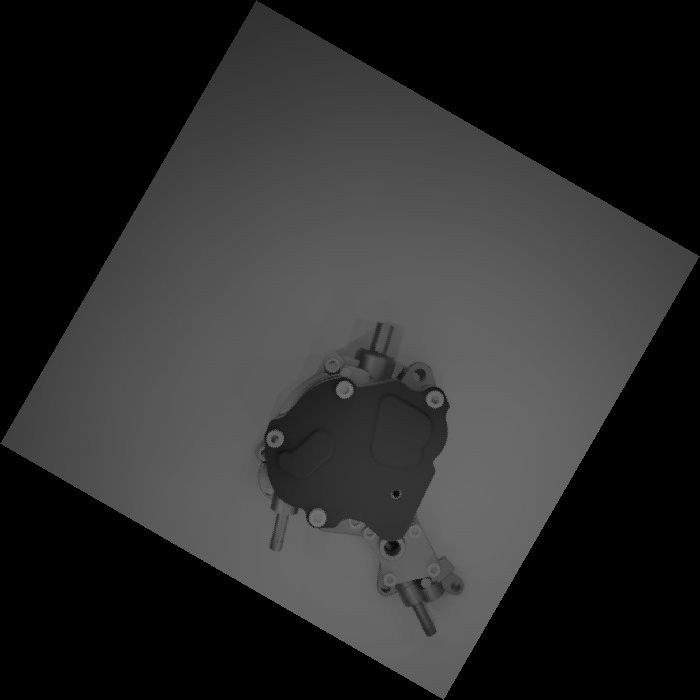

Sample 8/10:
Image: stage_7_perm_23_case_render_9_rot240_dark075.jpg
True Label: stage_7 (ID: 7)
Predicted Label: stage_7 (ID: 7)
Result: ✅ CORRECT
----------------------------------------


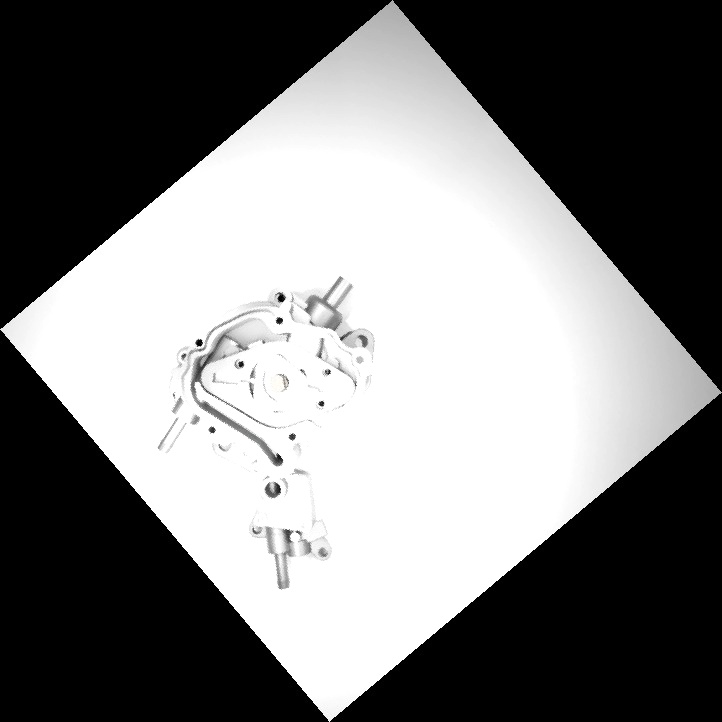

Sample 9/10:
Image: stage_5_perm_6_case_render_6_rot220_bright125.jpg
True Label: stage_5 (ID: 5)
Predicted Label: stage_5 (ID: 5)
Result: ✅ CORRECT
----------------------------------------


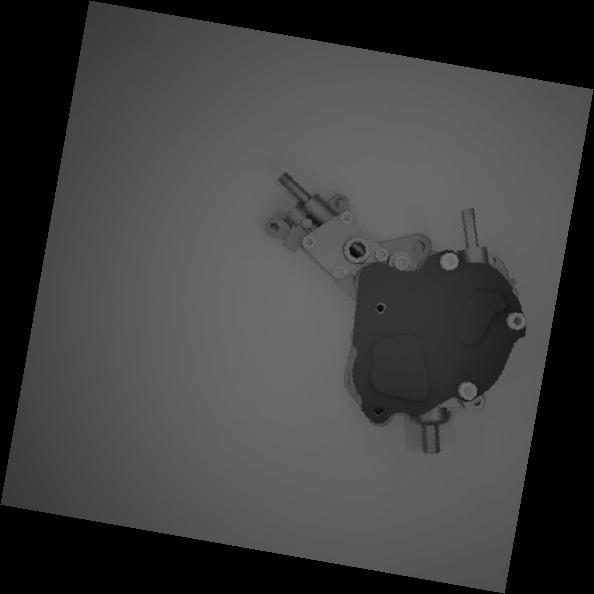

Sample 10/10:
Image: stage_7_perm_7_case_render_2_rot80_dark075.jpg
True Label: stage_7 (ID: 7)
Predicted Label: stage_7 (ID: 7)
Result: ✅ CORRECT
----------------------------------------

Evaluation Summary: 9/10 correct.


In [1]:
import os
import json
import torch
import random
from PIL import Image
from transformers import AutoImageProcessor
from train import DINOv2Classifier
from safetensors.torch import load_file as load_safetensors
from IPython.display import display
# Import the safetensors library

# CONFIG
repo_dir = os.getcwd().split('dslab25')[0] + 'dslab25/'
base_dir = repo_dir + "training/vacuum_pump"
image_dir = os.path.join(base_dir, "images/augmented")
coco_path = os.path.join(base_dir, "coco_annotations.json")
model_dir = os.path.join(repo_dir, "obj_detection/dino/final_model/")

print(f"Loading COCO annotations from: {coco_path}")
try:
	with open(coco_path, 'r') as f:
		coco_data = json.load(f)
except FileNotFoundError as e:
	print(f"Error: COCO annotation file not found at {coco_path}")
	raise e
except json.JSONDecodeError as e:
	print(f"Error: Could not decode JSON from {coco_path}")
	raise	e

# Create mappings for easy lookup
image_id_to_info = {img['id']: img for img in coco_data.get('images', [])}
image_id_to_annotation = {ann['image_id']: ann for ann in coco_data.get('annotations', [])}
category_id_to_name = {cat['id']: cat.get('name', f'category_{cat["id"]}') for cat in coco_data.get('categories', [])}

# --- Prepare list of all images with labels ---
all_samples = [] 
for img_id, annotation in image_id_to_annotation.items():
	if img_id in image_id_to_info:
		image_info = image_id_to_info[img_id]
		file_name = image_info['file_name']
		full_path = os.path.join(image_dir, file_name)
		true_category_id = annotation['category_id']
		if os.path.exists(full_path): # Check if image file exists
			all_samples.append({
				"image_path": full_path,
				"true_label_id": true_category_id
			})
		else:
			print(f"Warning: Image file not found: {full_path}")
	else:
		print(f"Warning: Image ID {img_id} found in annotations but not in images list.")

if not all_samples:
	raise Exception("Error: No valid image samples found. Check image paths and COCO file.")

print(f"Total valid samples found: {len(all_samples)}")

# --- Select 10 random samples ---
num_samples_to_test = min(10, len(all_samples))
if num_samples_to_test < 10:
	print(f"Warning: Fewer than 10 valid samples available. Testing on {num_samples_to_test}.")
random_samples = random.sample(all_samples, num_samples_to_test)

# --- Load Model and Processor ---
print("Loading image processor...")
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"Loading model structure...")
# Assuming the number of labels can be inferred or is known (e.g., from categories in coco)
num_labels = len(category_id_to_name) if category_id_to_name else 8 # Default to 8 if no categories
if not category_id_to_name:
	print("Warning: Could not determine number of labels from COCO categories. Defaulting to 8.")
		
model = DINOv2Classifier(num_labels=num_labels)

# Construct the expected path to the weights file
# Transformers Trainer saves as model.safetensors or pytorch_model.bin
safetensors_path = os.path.join(model_dir, "model.safetensors")
bin_path = os.path.join(model_dir, "pytorch_model.bin")

model_weights_path = None
if os.path.exists(safetensors_path):
	model_weights_path = safetensors_path
elif os.path.exists(bin_path):
	model_weights_path = bin_path
	
if model_weights_path:
	print(f"Loading model weights from: {model_weights_path}")
	try:
		# Use the correct loading function based on file type
		if model_weights_path.endswith(".safetensors"):
			state_dict = load_safetensors(model_weights_path, device=str(device))
		else: # Assume .bin or other torch.load compatible format
			# Explicitly set weights_only=False for older formats if needed, True is safer default
			state_dict = torch.load(model_weights_path, map_location=str(device), weights_only=True) 
			
		# Adjust for potential DDP prefix ('module.') if saved during distributed training
		if next(iter(state_dict)).startswith('module.'):
			state_dict = {k.partition('module.')[2]: v for k,v in state_dict.items()}
				
		model.load_state_dict(state_dict)
	except Exception as e:
		print(f"Error loading model weights: {e}")
		raise e
else:
	print(f"Error: Model weights not found in {model_dir} (checked for model.safetensors and pytorch_model.bin)")
	raise Exception("Model weights not found")
	

model.to(device)
model.eval() # Set model to evaluation mode
print("\n--- Starting Evaluation on Random Samples ---")
# --- Perform Inference ---
correct_predictions = 0
for i, sample in enumerate(random_samples):
	image_path = sample["image_path"]
	true_label_id = sample["true_label_id"]
	true_label_name = category_id_to_name.get(true_label_id, f"ID_{true_label_id}")

	try:
		image = Image.open(image_path).convert("RGB")
		display(image)  # Display the image in Jupyter

		inputs = processor(images=image, return_tensors="pt")
		pixel_values = inputs['pixel_values'].to(device)

		with torch.no_grad():
			outputs = model(pixel_values=pixel_values)

		logits = outputs['logits']
		predicted_label_id = logits.argmax(-1).item()
		predicted_label_name = category_id_to_name.get(predicted_label_id, f"ID_{predicted_label_id}")

		print(f"Sample {i+1}/{num_samples_to_test}:")
		print(f"Image: {os.path.basename(image_path)}")
		print(f"True Label: {true_label_name} (ID: {true_label_id})")
		print(f"Predicted Label: {predicted_label_name} (ID: {predicted_label_id})")
		if predicted_label_id == true_label_id:
			correct_predictions += 1
			print("Result: ✅ CORRECT")
		else:
			print("Result: ❌ INCORRECT")
		print("-" * 40)

	except Exception as e:
		print(f"Error processing sample {i+1} ({image_path}): {e}")
		print("-" * 40)

print(f"\nEvaluation Summary: {correct_predictions}/{num_samples_to_test} correct.")
